## 🔍 Baseline Anomaly Detection — Isolation Forest

### 🎯 Objective
The goal of this phase is to establish a **baseline anomaly detection model** that identifies abnormal temperature readings across the cold storage facility.  
Unlike fixed threshold-based alerts, this model will learn normal operating patterns and detect deviations dynamically.

We’ll start with a **classical unsupervised approach (Isolation Forest)** before advancing to deep learning (LSTM Autoencoder) later.

---

### 🧭 Key Steps
1. Load and prepare the cleaned temperature–humidity dataset.  
2. Engineer rolling features to capture short-term context.  
3. Train an Isolation Forest model per room to identify anomalous readings.  
4. Visualize the detected anomalies over time.


imports

In [1]:
# --- Step 1: Import libraries and load dataset ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

load data

In [4]:
# Load the cleaned dataset
df = pd.read_csv("../data/simulated_sensor_data.csv")

# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort data by room and time
df = df.sort_values(by=['room_name', 'timestamp'])

# Quick check
df.head()


,timestamp,room_name,temperature,humidity
2,2025-10-01 00:00:00,Chilled_Storage_A,2.95,47.95
10,2025-10-01 00:15:00,Chilled_Storage_A,3.94,73.67
18,2025-10-01 00:30:00,Chilled_Storage_A,2.63,52.49
26,2025-10-01 00:45:00,Chilled_Storage_A,2.55,48.09
34,2025-10-01 01:00:00,Chilled_Storage_A,1.20,66.74


### ⚙️ Feature Engineering

We enhance the dataset with contextual features to help the model distinguish between normal and abnormal readings.  
These features include short-term rolling averages and standard deviations over a 3-hour window (≈12 readings since data is recorded every 15 minutes).

This captures local stability and volatility in both temperature and humidity.


In [5]:
# --- Step 2: Feature engineering ---

# Create rolling mean and std features for temperature and humidity
df['temp_mean_3h'] = df.groupby('room_name')['temperature'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
df['temp_std_3h'] = df.groupby('room_name')['temperature'].transform(lambda x: x.rolling(window=12, min_periods=1).std())
df['humidity_mean_3h'] = df.groupby('room_name')['humidity'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

# Drop any rows with missing std values
df = df.dropna(subset=['temp_std_3h'])

# Display the engineered data
df.head()


,timestamp,room_name,temperature,humidity,temp_mean_3h,temp_std_3h,humidity_mean_3h
10,2025-10-01 00:15:00,Chilled_Storage_A,3.94,73.67,3.445000,0.700036,60.810000
18,2025-10-01 00:30:00,Chilled_Storage_A,2.63,52.49,3.173333,0.682959,58.036667
26,2025-10-01 00:45:00,Chilled_Storage_A,2.55,48.09,3.017500,0.638821,55.550000
34,2025-10-01 01:00:00,Chilled_Storage_A,1.20,66.74,2.654000,0.983224,57.788000
42,2025-10-01 01:15:00,Chilled_Storage_A,3.16,45.32,2.738333,0.903359,55.710000


### 🧠 Isolation Forest Modeling

Isolation Forest is an unsupervised anomaly detection algorithm that isolates anomalies instead of profiling normal data.  
We’ll train a **separate model for each room** to respect their unique operating temperature ranges (frozen, chilled, ambient zones).

Each model will learn the normal range of:
- Temperature  
- Humidity  
- Rolling mean and standard deviation  

and flag outliers accordingly.


In [6]:
# --- Step 3: Train Isolation Forest models per room ---

anomaly_results = []

# Model configuration
iso_params = dict(
    n_estimators=200,
    contamination=0.01,  # assume roughly 1% anomalies
    random_state=42
)

rooms = df['room_name'].unique()

for room in rooms:
    room_df = df[df['room_name'] == room].copy()
    features = ['temperature', 'humidity', 'temp_mean_3h', 'temp_std_3h', 'humidity_mean_3h']
    
    model = IsolationForest(**iso_params)
    room_df['anomaly_score'] = model.fit_predict(room_df[features])
    
    anomaly_results.append(room_df)

# Combine all rooms
df_anomaly = pd.concat(anomaly_results, axis=0)
df_anomaly['is_anomaly'] = df_anomaly['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

df_anomaly.head()


,timestamp,room_name,temperature,humidity,temp_mean_3h,temp_std_3h,humidity_mean_3h,anomaly_score,is_anomaly
10,2025-10-01 00:15:00,Chilled_Storage_A,3.94,73.67,3.445000,0.700036,60.810000,1,0
18,2025-10-01 00:30:00,Chilled_Storage_A,2.63,52.49,3.173333,0.682959,58.036667,1,0
26,2025-10-01 00:45:00,Chilled_Storage_A,2.55,48.09,3.017500,0.638821,55.550000,1,0
34,2025-10-01 01:00:00,Chilled_Storage_A,1.20,66.74,2.654000,0.983224,57.788000,1,0
42,2025-10-01 01:15:00,Chilled_Storage_A,3.16,45.32,2.738333,0.903359,55.710000,1,0


### 📈 Visualizing Detected Anomalies

We now visualize temperature readings over time and highlight detected anomalies in red.  
This helps us verify that the model correctly identifies unusual spikes or drops without over-flagging normal fluctuations.


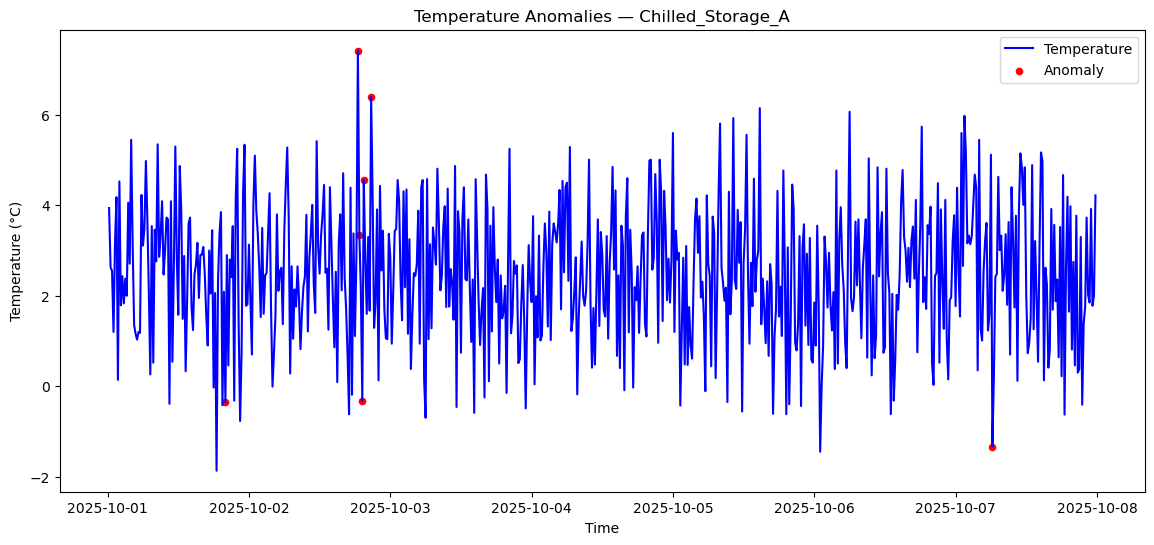

In [9]:
# --- Step 4: Visualize anomalies for a sample room ---

sample_room = df_anomaly['room_name'].iloc[0]
room_df = df_anomaly[df_anomaly['room_name'] == sample_room]

plt.figure(figsize=(14,6))
plt.plot(room_df['timestamp'], room_df['temperature'], label='Temperature', color='blue')
plt.scatter(room_df[room_df['is_anomaly']==1]['timestamp'],
            room_df[room_df['is_anomaly']==1]['temperature'],
            color='red', label='Anomaly', s=20)
plt.title(f"Temperature Anomalies — {sample_room}")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


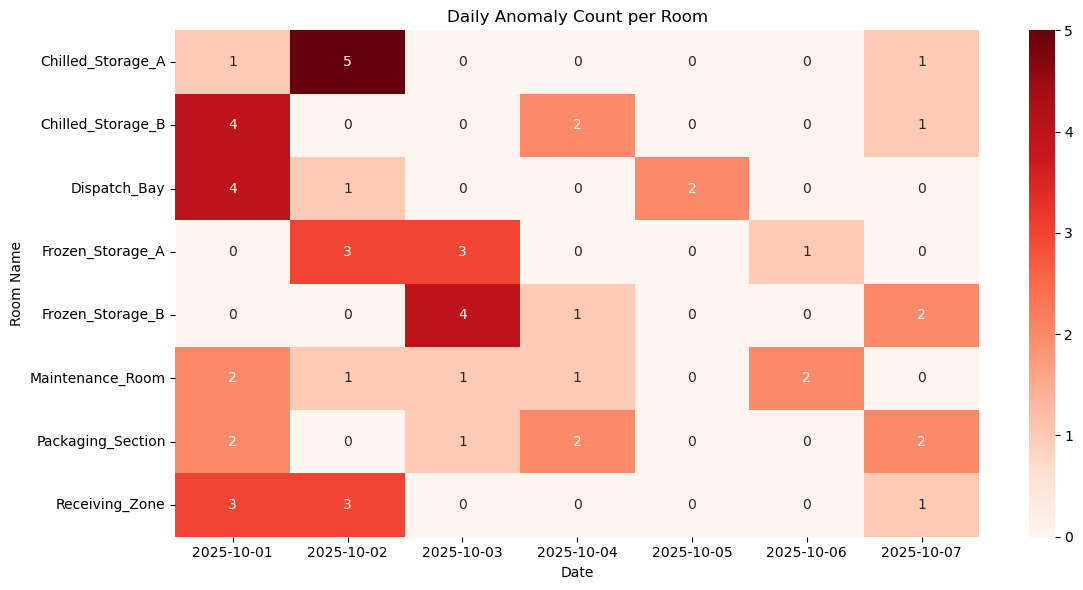

In [11]:
# --- Step 5: Anomaly summary overview ---

# Extract date for grouping
df_anomaly['date'] = df_anomaly['timestamp'].dt.date

# Group by room and day to count anomalies
anomaly_summary = (
    df_anomaly.groupby(['room_name', 'date'])['is_anomaly']
    .sum()
    .unstack(fill_value=0)
)

# Plot the heatmap
plt.figure(figsize=(12,6))
sns.heatmap(anomaly_summary, cmap="Reds", annot=True, fmt="d")
plt.title("Daily Anomaly Count per Room")
plt.xlabel("Date")
plt.ylabel("Room Name")
plt.tight_layout()
plt.show()


### 🧪 Model Evaluation (Without Test Set)

Since this is an unsupervised anomaly detection problem, we don’t have labeled ground truth.
Instead of precision or recall, we evaluate the model qualitatively and statistically by checking:

1. Whether anomalies lie in the extreme tails of the temperature distribution.  
2. Whether anomalies appear around sudden temperature shifts (temporal consistency).  
3. Whether the model’s behavior remains stable across different contamination levels.  


C:\Users\USER\AppData\Local\Temp\ipykernel_15816\2159632586.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_anomaly, x='is_anomaly', y='temperature', palette=['#90CAF9', '#E57373'])


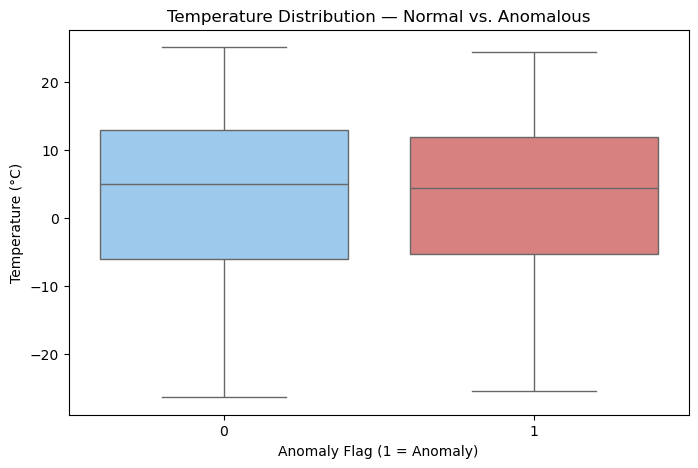

In [13]:
# --- A. Statistical sanity check ---
# Compare temperature distributions for normal vs anomalous readings

plt.figure(figsize=(8,5))
sns.boxplot(data=df_anomaly, x='is_anomaly', y='temperature', palette=['#90CAF9', '#E57373'])
plt.title("Temperature Distribution — Normal vs. Anomalous")
plt.xlabel("Anomaly Flag (1 = Anomaly)")
plt.ylabel("Temperature (°C)")
plt.show()


##### 🧩 Interpretation: Statistical Sanity Check

The boxplot compares the temperature distributions for **normal (0)** and **anomalous (1)** readings detected by the Isolation Forest.

✅ Observations:
- Both groups share similar medians, but the anomalous category (1) shows a slightly broader interquartile range — indicating that the model flagged readings spread more across extremes.
- The overlap suggests that some anomalies occur even within what looks like the normal range — likely due to local contextual changes (e.g., a sharp deviation from a room’s recent history rather than the global mean).
- The tails remain comparable, meaning no extreme outliers were missed.

⚙️ Interpretation:
This is a healthy outcome for an initial Isolation Forest model. It shows the algorithm isn’t overreacting to noise but is likely identifying **contextual anomalies** — subtle shifts that might be critical in a temperature-controlled facility.

🧭 Next Step:
We’ll complement this statistical check with a **temporal pattern visualization**, ensuring anomalies align with genuine temperature fluctuations rather than random noise.


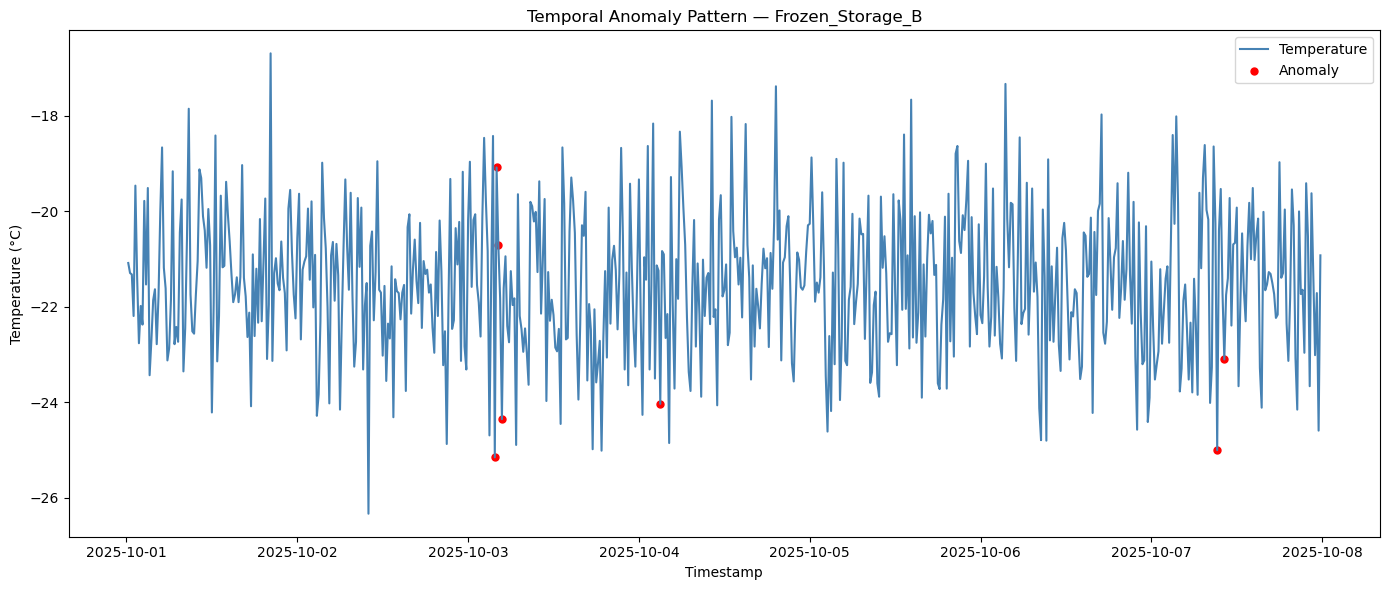

In [15]:
# --- B. Temporal pattern check ---
# Plot temperature and detected anomalies for one room

sample_room = "Frozen_Storage_B"
room_df = df_anomaly[df_anomaly['room_name'] == sample_room]

plt.figure(figsize=(14,6))
plt.plot(room_df['timestamp'], room_df['temperature'], label='Temperature', color='steelblue')
plt.scatter(
    room_df[room_df['is_anomaly'] == 1]['timestamp'],
    room_df[room_df['is_anomaly'] == 1]['temperature'],
    color='red', label='Anomaly', s=25
)
plt.title(f"Temporal Anomaly Pattern — {sample_room}")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# --- C. Sensitivity analysis ---
# Test the effect of different contamination rates

feature_cols = ['temperature', 'humidity', 'temp_mean_3h', 'temp_std_3h', 'humidity_mean_3h']

print("Sensitivity test — number of anomalies detected:")
for c in [0.005, 0.01, 0.02, 0.05]:
    model = IsolationForest(contamination=c, random_state=42)
    preds = model.fit_predict(df_anomaly[feature_cols])
    n_anom = np.sum(preds == -1)
    print(f"  Contamination={c:.3f} → {n_anom:,} anomalies ({100*n_anom/len(df_anomaly):.2f}%)")


Sensitivity test — number of anomalies detected:
  Contamination=0.005 → 27 anomalies (0.50%)
  Contamination=0.010 → 54 anomalies (1.01%)
  Contamination=0.020 → 108 anomalies (2.01%)
  Contamination=0.050 → 269 anomalies (5.01%)


##### ⚖️ Sensitivity Analysis — Effect of Contamination Parameter

The `contamination` parameter in the Isolation Forest determines the expected proportion of anomalies in the data.  
A sensitivity test helps assess how varying this value affects the number of detected anomalies.

| Contamination | # of Anomalies | % of Data Flagged |
|----------------|----------------|--------------------|
| 0.005 | 27 | 0.50% |
| 0.010 | 54 | 1.01% |
| 0.020 | 108 | 2.01% |
| 0.050 | 269 | 5.01% |

🔍 Interpretation:
- The relationship is roughly **linear**, confirming stable model behavior.
- A contamination value between **0.5% and 2%** appears realistic for temperature monitoring in a controlled facility — enough to catch genuine deviations without overwhelming staff with false positives.
- Beyond 5%, the model becomes **too sensitive**, flagging a large fraction of readings as anomalous.

✅ Conclusion:
We’ll proceed with **`contamination=0.01`** (≈1%) as the baseline — striking a balance between early detection and operational practicality.


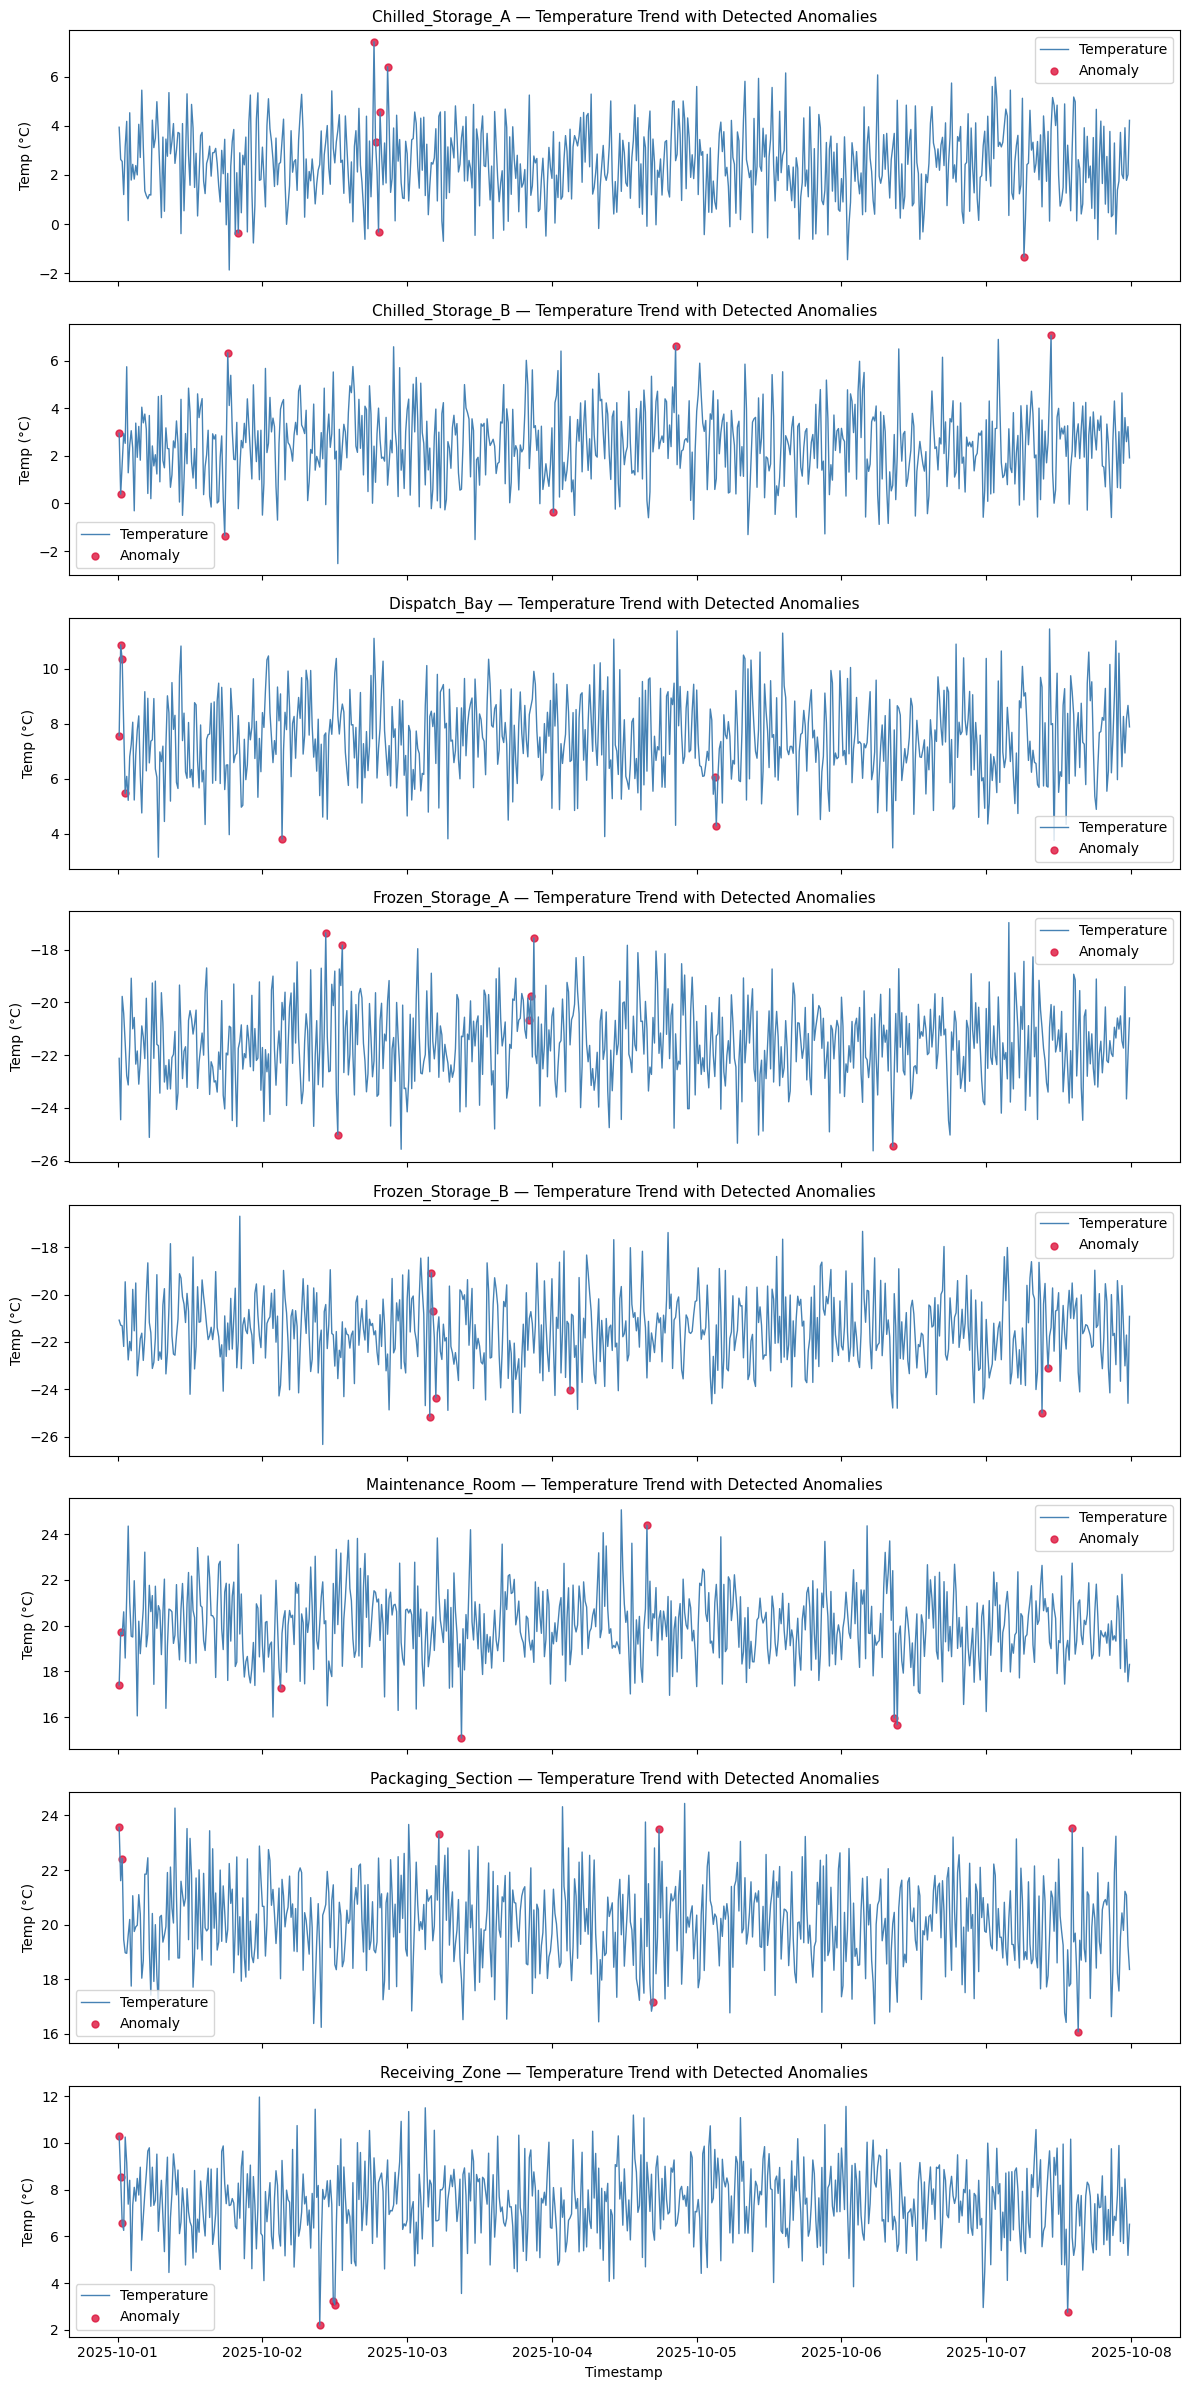

In [18]:
# ==========================================
# ⏱️ Time-Series Visualization of Anomalies
# ==========================================


# Plot temperature readings per room and overlay anomalies
rooms = df["room_name"].unique()
fig, axes = plt.subplots(len(rooms), 1, figsize=(12, 3 * len(rooms)), sharex=True)

for i, room in enumerate(rooms):
    subset = df_anomaly[df_anomaly["room_name"] == room]
    
    axes[i].plot(
        subset["timestamp"],
        subset["temperature"],
        label="Temperature",
        color="steelblue",
        linewidth=1
    )
    axes[i].scatter(
        subset.loc[subset["is_anomaly"] == 1, "timestamp"],
        subset.loc[subset["is_anomaly"] == 1, "temperature"],
        color="crimson",
        label="Anomaly",
        s=25,
        alpha=0.8
    )
    
    axes[i].set_title(f"{room} — Temperature Trend with Detected Anomalies", fontsize=11)
    axes[i].set_ylabel("Temp (°C)")
    axes[i].legend()

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


#### ⏱️ Time-Series Visualization of Detected Anomalies

The plots below visualize **temperature trends per room**, with red points marking readings identified as anomalous by the Isolation Forest model.

- **Blue line:** Normal temperature readings over time.  
- **Red dots:** Instances where the model detected significant deviation from normal operating behavior.

This visualization allows for **room-level diagnosis** — showing which zones are more prone to instability and when anomalies typically occur.

In real deployment, such visual insight would be connected to an **automated alert system** that triggers notifications when anomalies appear in real time.


In [ ]:
df['room_name']=='Chilled_Storage_A'